In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f8cb51aad68>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f8cb51fdeb8>,
 'id': 1,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'tobs': 65.0,
 'prcp': 0.08}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
first_row = session.query(Measurement).order_by(Measurement.date.desc()).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f8cb520aba8>,
 'id': 2724,
 'date': '2017-08-23',
 'station': 'USC00519397',
 'tobs': 81.0,
 'prcp': 0.0}

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

final_date = first_row.date

# Calculate the date one year from the last date in data set.
    
end_date = dt.datetime.strptime(final_date, '%Y-%m-%d')
start_date = end_date - dt.timedelta(days=365)
start_date_short = start_date.date()
end_date_short = end_date.date()
print(start_date_short)
# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement, Measurement.date, Measurement.prcp).\
                    filter((Measurement.date >= start_date_short) &\
                           (Measurement.date <= end_date_short)) 

# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(columns=['date','prcp'])

for record in results:
    precip_df = precip_df.append({'date': record.date,
                                  'prcp': record.prcp},
                                 ignore_index=True)

precip_df = precip_df[(precip_df['prcp'].notna())]

precip_df.set_index('date', inplace=True)

# Sort the dataframe by date

precip_df.sort_values(by=['date'])
precip_df



2016-08-23


,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-17,0.13
2017-08-19,0.09
2017-08-21,0.56


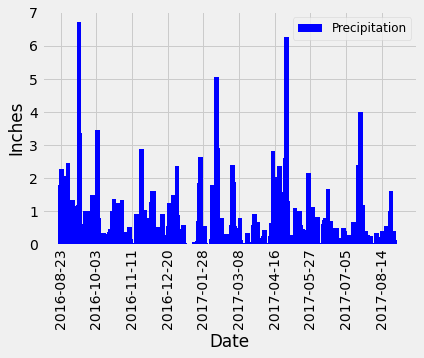

In [13]:

# Use Pandas Plotting with Matplotlib to plot the data

bars = precip_df["prcp"]

fig = plt.figure()
ax = fig.add_subplot()

plt.bar(precip_df.index.values, bars.values, label="Precipitation", color="b", align="center", width=5)
plt.xticks(np.arange(0, 400, step=39))

plt.legend(fontsize=12)       
plt.xticks(rotation = 90)
plt.ylabel("Inches")
plt.xlabel("Date")

plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precip_df["prcp"].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(func.count(Station.station.distinct())).all()
station_count

[(9,)]

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.date).\
              label('meas_count')).group_by(Measurement.station).order_by(desc('meas_count')).all()

highest = True

for station, count in most_active:
    if highest:
        active_station = station
        active_count = count
        highest = False
    print(station, count)  
    
print('')
print(active_station, active_count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511

USC00519281 2772


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
print(active_station, active_count)

results = session.query(Measurement, 
                        func.min(Measurement.tobs).label('min_temp'), 
                        func.max(Measurement.tobs).label('max_temp'),
                        func.avg(Measurement.tobs).label('avg_temp')).\
                        filter(Measurement.station == active_station)
                            
for record in results:
    print(f'Min temp for Station:{active_station} is {record.min_temp}') 
    print(f'Max temp for Station:{active_station} is {record.max_temp}') 
    print(f'Avg temp for Station:{active_station} is {record.avg_temp}') 


USC00519281 2772
Min temp for Station:USC00519281 is 54.0
Max temp for Station:USC00519281 is 85.0
Avg temp for Station:USC00519281 is 71.66378066378067


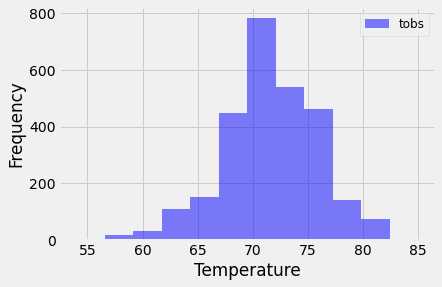

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results = session.query(Measurement, Measurement.tobs).\
                        filter(Measurement.station == active_station)

tobs_df = pd.DataFrame(columns=['tobs'])

for record in results:
    tobs_df = tobs_df.append({'tobs': record.tobs},
                                 ignore_index=True)
tobs_df

x = tobs_df['tobs'].values
num_bins = 12

n, bins, patches = plt.hist(x, num_bins, label="tobs", facecolor='blue', alpha=0.5)

plt.legend(fontsize=12)       

plt.ylabel("Frequency")
plt.xlabel("Temperature")

plt.show()                            

# Close session

In [19]:
# Close Session
session.close()